In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate
from scipy.stats import chi2_contingency
%matplotlib inline

from sklearn import neighbors
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

Use this dataset of airline arrival information to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.

In [2]:
airline = pd.read_csv("2004.csv.bz2")

In [3]:
#I begin exploring my data by seeing how long the dataset is. 
print(len(airline))

7129270


Because this dataset is so large, I am taking a random sample to use with my models. 

In [4]:
test = airline.sample(frac=0.05)

In [5]:
#Before I go any further I want to check in there are any null values in my dataset
print(test.isnull().sum())

Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                6386
CRSDepTime                0
ArrTime                7051
CRSArrTime                0
UniqueCarrier             0
FlightNum                 0
TailNum                   4
ActualElapsedTime      7051
CRSElapsedTime            0
AirTime                7051
ArrDelay               7051
DepDelay               6386
Origin                    0
Dest                      0
Distance                  0
TaxiIn                    0
TaxiOut                   0
Cancelled                 0
CancellationCode     350078
Diverted                  0
CarrierDelay              0
WeatherDelay              0
NASDelay                  0
SecurityDelay             0
LateAircraftDelay         0
dtype: int64


From the null values listed above, I can see that there are 7110 missing values for Arrival Delay. These could be due to the flight being cancelled or diverted. But regardless, these data points will not be able to accurately inform my model about how late flights will be.

In [6]:
# Dropping the rows with null values in the Arrival Delay column
test = test.dropna(axis=0, subset=['ArrDelay'])

### Continuous features and Arrival Delay

Next, I want to view the correlation of the continuous features to the outcome feature, Arrival Delay.

In [7]:
# I've isolated my features from the dataset
feature = test.loc[:,['ArrDelay', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 
                               'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 
                               'AirTime', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
                               'CancellationCode', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
                               'LateAircraftDelay']]

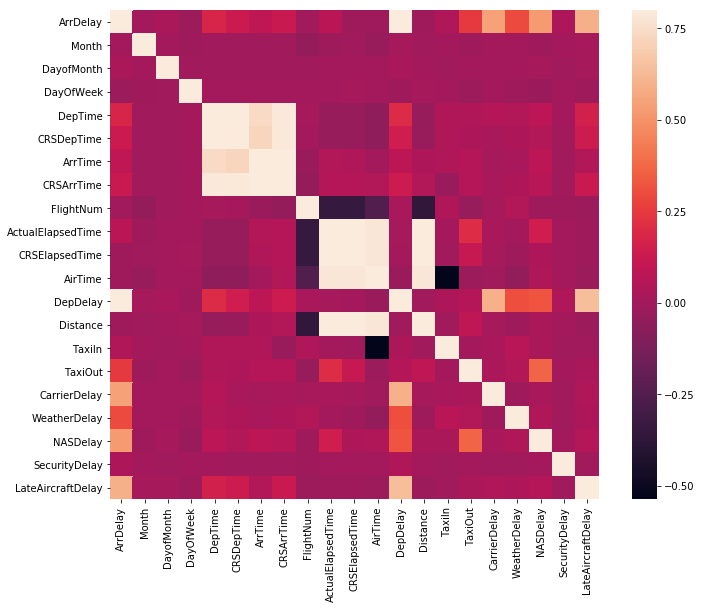

In [10]:
corrmat = feature.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [11]:
# The exact correlation numbers for all the features. 
corrmat

,ArrDelay,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,AirTime,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
ArrDelay,1.000000,0.006255,0.025254,-0.019260,0.181408,0.127048,0.094767,0.126195,-0.001603,0.074344,...,-0.006828,0.909223,-0.012850,0.043875,0.249068,0.546419,0.297255,0.526506,0.037373,0.591162
Month,0.006255,1.000000,0.005477,-0.008639,0.000943,-0.000183,-0.002650,-0.002614,-0.039129,-0.005772,...,-0.026227,0.016411,-0.001275,0.001206,-0.013482,0.005830,0.001359,-0.012379,0.005770,0.013568
DayofMonth,0.025254,0.005477,1.000000,0.000183,-0.001749,-0.002855,-0.002737,-0.002941,-0.001130,0.004797,...,0.003085,0.021287,0.001871,0.000444,0.006404,0.004852,0.009993,0.014008,-0.001443,0.016356
DayOfWeek,-0.019260,-0.008639,0.000183,1.000000,0.006297,0.006945,0.006756,0.007906,0.003847,0.005089,...,0.006845,-0.006137,0.012264,0.001848,-0.016177,0.004199,-0.009829,-0.020543,0.004802,-0.009485
DepTime,0.181408,0.000943,-0.001749,0.006297,1.000000,0.975112,0.738989,0.790044,0.013055,-0.031008,...,-0.055982,0.201030,-0.031910,0.044137,0.038160,0.055690,0.052244,0.083801,0.001560,0.160750
CRSDepTime,0.127048,-0.000183,-0.002855,0.006945,0.975112,1.000000,0.724671,0.787473,0.008532,-0.030460,...,-0.052184,0.143101,-0.028369,0.040309,0.036126,0.021020,0.037567,0.052026,-0.002498,0.132625
ArrTime,0.094767,-0.002650,-0.002737,0.006756,0.738989,0.724671,1.000000,0.893139,-0.024188,0.049328,...,0.006503,0.089416,0.035505,0.043607,0.058075,0.012414,0.018670,0.085196,0.000320,0.052470
CRSArrTime,0.126195,-0.002614,-0.002941,0.007906,0.790044,0.787473,0.893139,1.000000,-0.036136,0.058290,...,0.049944,0.136226,0.050162,-0.022700,0.054981,0.018913,0.034332,0.068693,-0.001886,0.124046
FlightNum,-0.001603,-0.039129,-0.001130,0.003847,0.013055,0.008532,-0.024188,-0.036136,1.000000,-0.348135,...,-0.254654,0.016935,-0.359946,0.043486,-0.031795,0.016486,0.050919,-0.009317,-0.005197,-0.019328
ActualElapsedTime,0.074344,-0.005772,0.004797,0.005089,-0.031008,-0.030460,0.049328,0.058290,-0.348135,1.000000,...,0.779510,0.012761,0.969229,0.005971,0.207603,0.018831,0.002821,0.146705,0.009209,-0.005880


In [12]:
# Sorting features that correlate to Arrival Delay by descending order. 
corrmat['ArrDelay'].sort_values(ascending=False)

ArrDelay             1.000000
DepDelay             0.909223
LateAircraftDelay    0.591162
CarrierDelay         0.546419
NASDelay             0.526506
WeatherDelay         0.297255
TaxiOut              0.249068
DepTime              0.181408
CRSDepTime           0.127048
CRSArrTime           0.126195
ArrTime              0.094767
ActualElapsedTime    0.074344
TaxiIn               0.043875
SecurityDelay        0.037373
DayofMonth           0.025254
Month                0.006255
FlightNum           -0.001603
AirTime             -0.006828
Distance            -0.012850
CRSElapsedTime      -0.012933
DayOfWeek           -0.019260
Name: ArrDelay, dtype: float64

### Categorical features and Arrival Delay

Now I am going to look at the relationship between the categorical features and Arrival Delay.

In [13]:
# I've isolated my categorical features and Arrival Delay
categories = test.loc[:,['ArrDelay', 'UniqueCarrier', 'Origin', 'Dest']]

In [14]:
# Recode ArrDelay column to binary.
categories['ArrDelay'] = np.where(categories['ArrDelay']>=30, 1, 0)

Next I am going to use a Chi-squared test to determine whether there is a significant difference between the expected frequencies and the observed frequencies between the Unique Carrier, Origin, and Destination and the Arrival Delay. 

In [15]:
def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(chi2_contingency(ctsum.fillna(0)))

test_df = pd.DataFrame(categories, columns=['ArrDelay', 'UniqueCarrier'])
chisq_of_df_cols(test_df, 'ArrDelay', 'UniqueCarrier')

(1343.0456588368224,
 2.3850829416403757e-274,
 18,
 array([[ 30297.47088975,   4048.52911025],
        [  7124.04282611,    951.95717389],
        [  4025.13712426,    537.86287574],
        [ 13141.90069631,   1756.09930369],
        [ 11118.30556963,   1485.69443037],
        [ 29881.10781225,   3992.89218775],
        [ 11984.55248088,   1601.44751912],
        [  7096.69694602,    948.30305398],
        [  2056.23375776,    274.76624224],
        [  8528.38608752,   1139.61391248],
        [ 20387.67679508,   2724.32320492],
        [ 21750.56017378,   2906.43982622],
        [ 15791.80468958,   2110.19531042],
        [ 19815.17756351,   2647.82243649],
        [  3307.0872406 ,    441.9127594 ],
        [ 24332.5405294 ,   3251.4594706 ],
        [ 18164.72138129,   2427.27861871],
        [ 43396.14745301,   5798.85254699],
        [ 16026.44998326,   2141.55001674]]))

In [16]:
test_df = pd.DataFrame(categories, columns=['ArrDelay', 'Origin'])
chisq_of_df_cols(test_df, 'ArrDelay', 'Origin')

(3229.9730193380092, 0.0, 280, array([[  2.95511930e+02,   3.94880700e+01],
        [  1.32318775e+02,   1.76812254e+01],
        [  1.63016730e+03,   2.17832697e+02],
        [  7.23342635e+01,   9.66573654e+00],
        [  1.14676271e+01,   1.53237287e+00],
        [  1.46432777e+02,   1.95672227e+01],
        [  1.76425033e+02,   2.35749672e+01],
        [  4.76347589e+01,   6.36524113e+00],
        [  2.64637549e+00,   3.53624507e-01],
        [  2.29352543e+01,   3.06474573e+00],
        [  1.57018279e+02,   2.09817208e+01],
        [  1.81717784e+02,   2.42822162e+01],
        [  1.94067536e+01,   2.59324639e+00],
        [  7.82445021e+02,   1.04554979e+02],
        [  3.92545698e+02,   5.24543019e+01],
        [  8.62718411e+02,   1.15281589e+02],
        [  1.05855020e+01,   1.41449803e+00],
        [  1.78339244e+04,   2.38307556e+03],
        [  1.04090769e+02,   1.39092306e+01],
        [  1.70426582e+03,   2.27734183e+02],
        [  1.75542908e+02,   2.34570923e+01],
    

In [17]:
test_df = pd.DataFrame(categories, columns=['ArrDelay', 'Dest'])
chisq_of_df_cols(test_df, 'ArrDelay', 'Dest')

(3320.0560591058261, 0.0, 279, array([[  3.02568931e+02,   4.04310687e+01],
        [  1.27026024e+02,   1.69739764e+01],
        [  1.67868419e+03,   2.24315813e+02],
        [  6.52772622e+01,   8.72273785e+00],
        [  7.93912648e+00,   1.06087352e+00],
        [  1.51725528e+02,   2.02744718e+01],
        [  1.79953533e+02,   2.40464665e+01],
        [  3.79313821e+01,   5.06861794e+00],
        [  4.41062582e+00,   5.89374179e-01],
        [  2.64637549e+01,   3.53624507e+00],
        [  1.41140026e+02,   1.88599737e+01],
        [  1.64075281e+02,   2.19247195e+01],
        [  1.67603781e+01,   2.23962188e+00],
        [  8.05380275e+02,   1.07619725e+02],
        [  3.51967941e+02,   4.70320595e+01],
        [  9.16528046e+02,   1.22471954e+02],
        [  2.64637549e+00,   3.53624507e-01],
        [  1.81603108e+04,   2.42668924e+03],
        [  1.23497523e+02,   1.65024770e+01],
        [  1.75366483e+03,   2.34335174e+02],
        [  1.87892660e+02,   2.51073400e+01],
    

From my results above, I can see that only the Unique Carrier features has a significant p-value of 2.3850829416403757e-274,. Now from my inspection of both the continuous and categorical features I am going to form a dataset with my two highest correlated delay features, the Unique Carrier feature, and the Taxi Out feature. With this dataset I will then complete my models. 

In [18]:
final_features = test.loc[:,['ArrDelay', 'DepDelay', 'LateAircraftDelay', 'UniqueCarrier', 'TaxiOut']]

In [19]:
testing_dataset = pd.get_dummies(final_features)

In [20]:
# These are my X and Y variables. 
X = testing_dataset.iloc[:, 1:]
Y = testing_dataset.ArrDelay

## KNN Regression Model

In [21]:
neighbors = neighbors.KNeighborsRegressor(n_neighbors=5)
neighbors.fit(X,Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [22]:
knn_score = cross_val_score(neighbors, X, Y, cv=5)
print('\nEach Cross Validated R2 score: \n', knn_score)
print("\nOverall KNN Regression R2: %0.2f (+/- %0.2f)\n" % (knn_score.mean(), knn_score.std() * 2))


Each Cross Validated R2 score: 
 [ 0.89160733  0.88466635  0.89237153  0.88127174  0.87674122]

Overall KNN Regression R2: 0.89 (+/- 0.01)



## Random Forest Regression Model

In [23]:
rfr = ensemble.RandomForestRegressor()
rfr.fit(X,Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [24]:
rfr_score = cross_val_score(rfr, X, Y, cv=5)
print('\nEach Cross Validated R2 score: \n', rfr_score)
print("\nOverall Random Forest Regression R2: %0.2f (+/- %0.2f)\n" % (rfr_score.mean(), rfr_score.std() * 2))


Each Cross Validated R2 score: 
 [ 0.89825745  0.8864123   0.90165287  0.89269906  0.88355643]

Overall Random Forest Regression R2: 0.89 (+/- 0.01)



### Summary

This dataset was challenging because of its size and the large number of unique datapoints. Many of my commands and models took a long time to load with only 5% of the original dataset. Because of the size, my initial focus was to narrow down the features to the most relevant for the outcome of interest. 

My continuous features showed that the five other delay features all correlated with Arrival delay. This isn't surprising that various types of delay lead to a delay in arrival. So initially, I was able to create very accurate models with only these delay features. However, an airline company would likely find a model centered around the recorded delay not very useful because the delay for a flight will likely be a last minute change. So such a model would likely do poorly in reality when you want to predict the delay before it starts happening. 

The categorical features were interesting because the different carriers were the only feature that dramatically impacted arrival delay.

I decided to select the two most correlated delay features, add the Unique Carrier feature, and then include the Taxi out feature which is the only continuous feature that correlates well with arrival delay but is not a delay feature itself. Because this challenge only asked me to predict how late flights will be rather than explain why these flights are late, I decided to use several black box models. I can see from my results that the KNN and Random Forest models are all very similar in their accuracy. I had attempted to run a Support Vector Regression model as well, but it kept crashing the program. 

Overall, I am happy with my results because I was able to achieve 89% accuracy with only four features and 5% of the dataset. 